In [1]:
%run notebook_setup

If you have not already read it, you may want to start with the first tutorial: [Getting started with The Joker](1-Getting-started.ipynb).

# Sampling over long-term velocity trend parameters

In addition to the default linear parameters (see [Tutorial 1](1-Getting-started.ipynb), or the documentation for ``JokerSamples.default()``), *The Joker* allows adding linear parameters to include a long-term polynomial velocity trend. While *The Joker* formally only works for the two-body problem, if the system is a triple, and the outer body is in a significantly longer period orbit, you may be able to represent its perturbation to the primary as a smooth polynomial (in time) over the observation window you have. Below, we will show this with an example

First, some imports we will need later:

In [2]:
import astropy.table as at
import astropy.units as u
import numpy as np
import thejoker as tj

%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# set up a random number generator to ensure reproducibility
rnd = np.random.default_rng(seed=123)

Let's start by loading some pre-generated data meant to represent radial velocity observations of a single luminous source with two faint companions: one on a shorter period orbit, the other with a period ~ 10x longer.

In [4]:
data = tj.RVData.guess_from_table(at.QTable.read("data-triple.ecsv"))
data = data[rnd.choice(len(data), size=16, replace=False)]  # downsample data

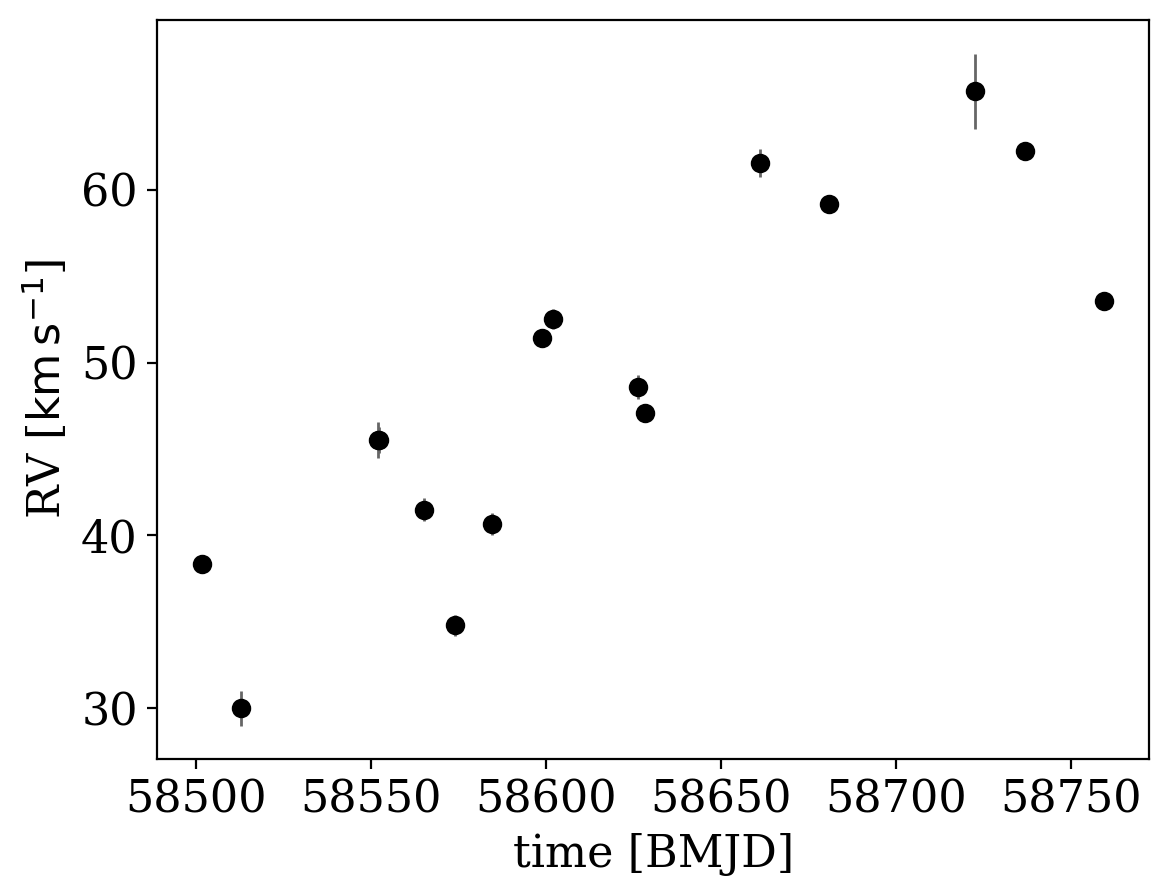

In [5]:
_ = data.plot()

Let's first pretend that we don't know it is a triple, and try generating orbit samples assuming a binary with no polynomial velocity trend. We will set up the default prior with some reasonable parameters that we have used in previous tutorials, and generate a big cache of prior samples:

In [6]:
prior = tj.JokerPrior.default(
    P_min=2 * u.day,
    P_max=1e3 * u.day,
    sigma_K0=30 * u.km / u.s,
    sigma_v=100 * u.km / u.s,
)
prior_samples = prior.sample(size=250_000, rng=rnd)

Now we can run *The Joker* to generate posterior samples:

In [7]:
joker = tj.TheJoker(prior, rng=rnd)
samples = joker.rejection_sample(data, prior_samples, max_posterior_samples=128)
samples

<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>

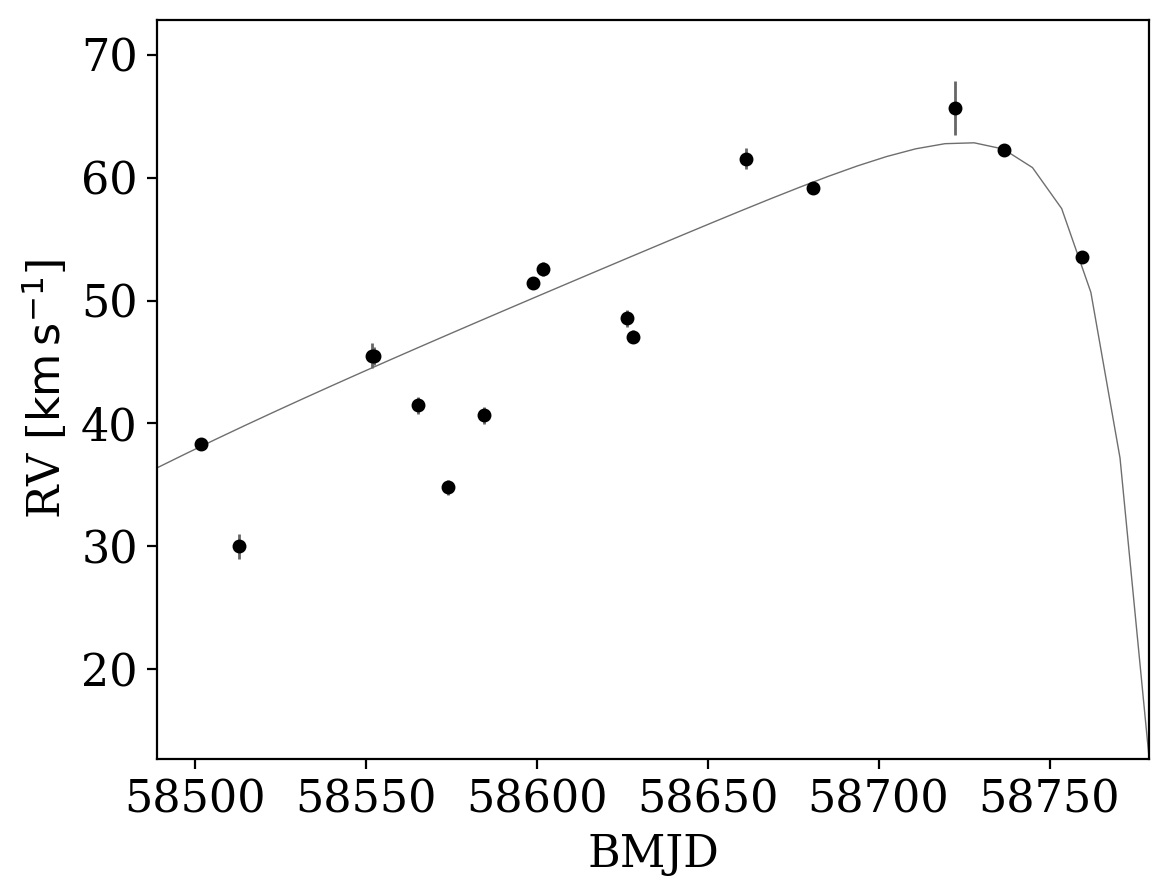

In [8]:
_ = tj.plot_rv_curves(samples, data=data)

Only one sample was returned, and it's not a very good fit to the data (see the plot above). This is because the data were generated from a hierarchical triple system, but fit as a two-body system. Let's now try generating Keplerian orbit samples for the inner binary, while including a polynomial trend in velocity to capture the long-term trend from the outer companion. To do this, we specify the number of polynomial trend coefficients to sample over: 1 is constant, 2 is linear, 3 is quadratic, etc. We also have to specify the standard deviations of the Gaussian priors on the trend parameters, so the units have to be set accordingly:

In [9]:
prior_trend = tj.JokerPrior.default(
    P_min=2 * u.day,
    P_max=1e3 * u.day,
    sigma_K0=30 * u.km / u.s,
    sigma_v=[100 * u.km / u.s, 0.5 * u.km / u.s / u.day, 1e-2 * u.km / u.s / u.day**2],
    poly_trend=3,
)

Notice the additional parameters `v1`, `v2` in the prior: 

In [10]:
prior_trend

<JokerPrior [P, e, omega, M0, s, K, v0, v1, v2]>

We are now set up to generate prior samples and run *The Joker* including the new linear trend parameters:

In [11]:
prior_samples_trend = prior_trend.sample(size=250_000, rng=rnd)
joker_trend = tj.TheJoker(prior_trend, rng=rnd)
samples_trend = joker_trend.rejection_sample(
    data, prior_samples_trend, max_posterior_samples=128
)
samples_trend

<JokerSamples [P, e, omega, M0, s, K, v0, v1, v2] (1 samples)>

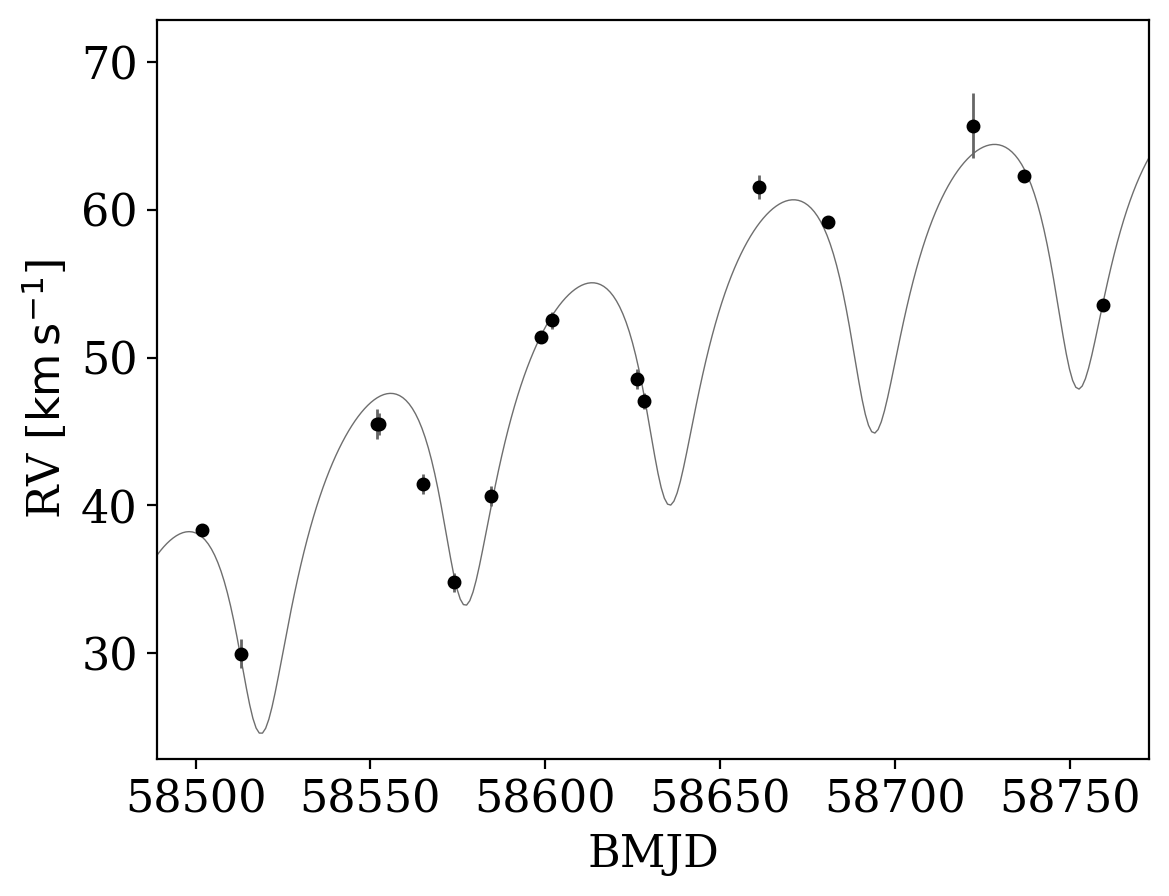

In [12]:
_ = tj.plot_rv_curves(samples_trend, data=data)

Those orbit samples look much better at matching the data! In a real-world situation with these data and results, given that the samples look like they all share a similar period, at this point I would start standard MCMC to continue generating samples. But, that is covered in [Tutorial 4](4-Continue-sampling-mcmc.ipynb), so for now, we will proceed with only the samples returned from The Joker.

So how do the sample values compare to the truth? I cached the true orbital parameter values for the inner binary of this system:

In [13]:
import pickle

with open("true-orbit-triple.pkl", "rb") as f:
    truth = pickle.load(f)

Truth:

In [14]:
truth["P"], truth["e"], truth["K"]

(<Quantity 58.63210685 d>, <Quantity 0.25>, <Quantity 7.37900547 km / s>)

Assuming binary:

In [15]:
samples["P"], samples["e"], samples["K"]

(<Quantity [546.13967944] d>,
 <Quantity [0.674905]>,
 <Quantity [-51.76894619] km / s>)

Assuming binary + quadratic velocity trend:

In [16]:
samples_trend.mean()["P"], samples_trend.mean()["e"], samples_trend.mean()["K"]

(<Quantity [58.39243129] d>,
 <Quantity [0.31584264]>,
 <Quantity [8.79219835] km / s>)

The period and semi-amplitude values we infer from including the velocity trend is less biased. Hurrah!